In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from skimage.feature import hog

In [2]:
# Function to load images from folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    return images

In [3]:
# Define paths for different categories
consonant_path = '../nepali_characters_dataset/consonants/'
numeral_path = '../nepali_characters_dataset/numerals/'
vowel_path = '../nepali_characters_dataset/vowels/'

In [4]:
# Load data for consonants
consonant_data = [load_images_from_folder(consonant_path + str(i)) for i in range(1, 37)]
# Load data for numerals
numeral_data = [load_images_from_folder(numeral_path + str(i)) for i in range(10)]
# Load data for vowels
vowel_data = [load_images_from_folder(vowel_path + str(i)) for i in range(1, 13)]

In [5]:
# Combine data from all categories
combined_data = consonant_data + numeral_data + vowel_data

In [6]:
total_samples = sum(len(data) for data in combined_data)
print("Total number of samples:", total_samples)

Total number of samples: 91112


In [7]:
# Preprocess data
def preprocess_data(data):
    # Resize images to a fixed size (e.g., 32x32 pixels)
    resized_images = [cv2.resize(img, (32, 32)) for img in data]
    # Convert images to numpy array and normalize pixel values (0 to 1)
    processed_data = np.array(resized_images) / 255.0
    # Expand dimensions to add channel dimension (for grayscale images)
    processed_data = np.expand_dims(processed_data, axis=-1)
    return processed_data

In [8]:
# Load and preprocess data
X = np.concatenate([preprocess_data(data) for data in combined_data])

In [9]:
# Generate labels for each category
y = np.concatenate([np.full(len(data), i) for i, data in enumerate(combined_data)])

In [10]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Data augmentation
train_img_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [12]:
# Define image dimensions and number of classes
img_height, img_width = 32, 32
num_classes = 36 + 10 + 12  # Total number of classes

In [13]:
# Create data generators
batch_size = 32
train_gen = train_img_datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True)
test_gen = ImageDataGenerator().flow(X_test, y_test, batch_size=batch_size, shuffle=False)

In [14]:
# Build the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [15]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

In [16]:
# Train the model
history = model.fit(train_gen, epochs=20, validation_data=test_gen)

Epoch 1/20


2278/2278 [==============================] - 70s 29ms/step - loss: 1.6087 - accuracy: 0.5547 - val_loss: 0.7369 - val_accuracy: 0.7802
Epoch 2/20
2278/2278 [==============================] - 64s 28ms/step - loss: 0.7593 - accuracy: 0.7754 - val_loss: 0.4620 - val_accuracy: 0.8549
Epoch 3/20
2278/2278 [==============================] - 65s 29ms/step - loss: 0.5679 - accuracy: 0.8307 - val_loss: 0.3430 - val_accuracy: 0.8967
Epoch 4/20
2278/2278 [==============================] - 66s 29ms/step - loss: 0.4773 - accuracy: 0.8564 - val_loss: 0.3535 - val_accuracy: 0.8905
Epoch 5/20
2278/2278 [==============================] - 65s 28ms/step - loss: 0.4198 - accuracy: 0.8729 - val_loss: 0.2820 - val_accuracy: 0.9137
Epoch 6/20
2278/2278 [==============================] - 67s 29ms/step - loss: 0.3823 - accuracy: 0.8826 - val_loss: 0.2870 - val_accuracy: 0.9120
Epoch 7/20
2278/2278 [==============================] - 66s 29ms/step - loss: 0.3544 - accuracy: 0.8917 - val_loss: 0.2551

In [22]:
# Evaluate the model and print metrics
model.evaluate(test_gen)
print('Training Loss:', history.history['loss'][-1], 
      '\nValidation Loss:', history.history['val_loss'][-1], 
      '\nTraining Accuracy:', history.history['accuracy'][-1], 
      '\nValidation Accuracy:', history.history['val_accuracy'][-1])

570/570 [==============================] - 3s 5ms/step - loss: 0.1958 - accuracy: 0.9411
Training Loss: 0.22043243050575256 
Validation Loss: 0.1957756131887436 
Training Accuracy: 0.9318141341209412 
Validation Accuracy: 0.9410634636878967


In [18]:
# Save the model
model.save('recognition_model_cnn.keras')

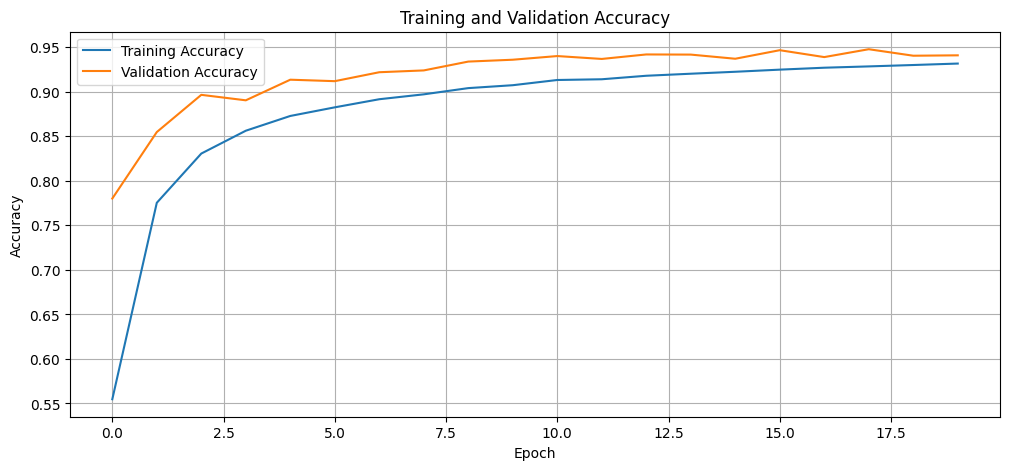

In [19]:
# Plot training and validation accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

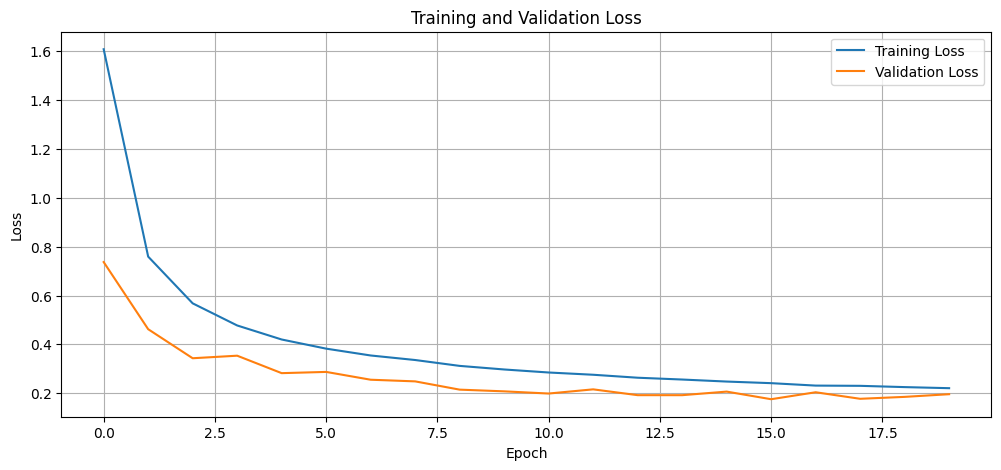

In [20]:
# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()